In [1]:
import itertools
import pandas as pd
import numpy as np

#helper functions to generate the testing dataset
def create_applicant(counter, school, gpa, degree, location, gender, vs, wa, dis, race):
    return {
        'Applicant ID': counter,
        'School Name': school,
        'GPA': gpa,
        'Degree': degree,
        'Location': location,
        'Gender': gender,
        'Veteran status': vs,
        'Work authorization': wa,
        'Disability': dis,
        'Ethnicity': race,
        'Role 1': 'N/A',
        'Start 1': 'N/A',
        'End 1': 'N/A',
        'Role 2': 'N/A',
        'Start 2': 'N/A',
        'End 2': 'N/A',
        'Role 3': 'N/A',
        'Start 3': 'N/A',
        'End 3': 'N/A'
    }

def generate_applicants():
    schools = ['State Providence College', 'Providence State University', 'Providence School', 'Providence University']
    locations = ['Miami', 'Chicago', 'Boston', 'Providence']
    degrees = ['Phd', 'Bachelors', 'Masters']
    genders = ['M', 'F']
    gpa_increments = [2.00 + i * 0.2 for i in range(11)]
    applicant_list = []
    counter = 1

    attributes = list(itertools.product(
        gpa_increments, schools, [0], [0], locations, degrees, [0, 1], [0, 1], genders
    ))

    for gpa, school, vs, wa, location, degree, race, dis, gender, in attributes:
        applicant = create_applicant(counter, school, gpa, degree, location, gender, vs, wa, dis, race)
        applicant_list.append(applicant)
        counter += 1

    return applicant_list


In [2]:
#generate applicant pool and save to a csv file
applicants = generate_applicants()
applicants = pd.DataFrame(applicants)
applicants.to_csv('applicants.csv',index = False)

## We then submit this csv to the resume scorer API

In [3]:
#read the result of resume scorer
resume_score_result = pd.read_csv('resume_score_result.csv')
applicants['Resume score'] = resume_score_result['score']
applicants.to_csv('candidates.csv',index = False)

## We then submit this csv to the candidate prediction API

In [4]:
#read the result of resume scorer
candidate_prediction_result = pd.read_csv('candidate_eval_result.csv')
candidates = applicants.copy()
candidates['prediction'] = candidate_prediction_result['prediction']

In [5]:
#define evaluation metrics
def spd(sensitive_attribute, dataset, predicted_labels, majority_class, minority_class):
    """
    Calculate the Statistical Parity Difference (SPD) between majority and minority classes based on predicted labels.

    Parameters:
    - sensitive_attribute (str): Name of the column representing the sensitive attribute.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute and true outcome variable.
    - predicted_labels (pd.Series): Predicted labels for the outcome variable.
    - majority_class: Value representing the majority class in the sensitive attribute.
    - minority_class: Value representing the minority class in the sensitive attribute.

    Returns:
    - spd (float): Statistical Parity Difference between majority and minority classes.
    """
    spd_val = np.mean(predicted_labels[sensitive_attribute == minority_class]) - np.mean(predicted_labels[sensitive_attribute == majority_class])
    return spd_val

def di(sensitive_attribute, dataset, predicted_labels, majority_class, minority_class):
    """
    Calculate the Disparate Impact (DI) between majority and minority classes based on predicted labels.

    Parameters:
    - sensitive_attribute (str): Name of the column representing the sensitive attribute.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute and true outcome variable.
    - predicted_labels (pd.Series): Predicted labels for the outcome variable.
    - majority_class: Value representing the majority class in the sensitive attribute.
    - minority_class: Value representing the minority class in the sensitive attribute.

    Returns:
    - di (float): Disparate Impact between majority and minority classes.
    """
    di_val = np.mean(predicted_labels[sensitive_attribute == minority_class]) / np.mean(predicted_labels[sensitive_attribute == majority_class])
    return di_val

In [6]:
#calculate the evaluation metrics for the resume scorer model on gender
rs_spd_gender = spd(applicants['Gender'],applicants,applicants['Resume score'],'M','F')
rs_di_gender = di(applicants['Gender'],applicants,applicants['Resume score'],'M','F')
#calculate the evaluation metrics for the resume scorer model on disability
rs_spd_dis = spd(applicants['Disability'],applicants,applicants['Resume score'],0,1)
rs_di_dis = di(applicants['Disability'],applicants,applicants['Resume score'],0,1)

In [7]:
print(f'The statistical parity difference on gender for the resume scorer model is {rs_spd_gender}')
print(f'The disparate impact on gender for the resume scorer model is {rs_di_gender}')
print(f'The statistical parity difference on disability for the resume scorer model is {rs_spd_dis}')
print(f'The disparate impact on disability for the resume scorer model is {rs_di_dis}')

The statistical parity difference on gender for the resume scorer model is 0.15704071969696898
The disparate impact on gender for the resume scorer model is 1.0320354440454274
The statistical parity difference on disability for the resume scorer model is 0.09684185606060591
The disparate impact on disability for the resume scorer model is 1.0196346475257734


In [8]:
#calculate the evaluation metrics for the candidates evaluation model on gender
ce_spd_gender = spd(candidates['Gender'],candidates,candidates['prediction'],'M','F')
ce_di_gender = di(candidates['Gender'],candidates,candidates['prediction'],'M','F')
#calculate the evaluation metrics for the candidates evaluation model on disability
ce_spd_dis = spd(candidates['Disability'],candidates,candidates['prediction'],0,1)
ce_di_dis = di(candidates['Disability'],candidates,candidates['prediction'],0,1)

In [9]:
print(f'The statistical parity difference on gender for the candidates evaluation model is {ce_spd_gender}')
print(f'The disparate impact on gender for the candidates evaluation model is {ce_di_gender}')
print(f'The statistical parity difference on disability for the candidates evaluation model is {ce_spd_dis}')
print(f'The disparate impact on disability for the candidates evaluation model is {ce_di_dis}')

The statistical parity difference on gender for the candidates evaluation model is -0.2277462121212121
The disparate impact on gender for the candidates evaluation model is 0.6179507545671168
The statistical parity difference on disability for the candidates evaluation model is -0.007102272727272707
The disparate impact on disability for the candidates evaluation model is 0.9853801169590644


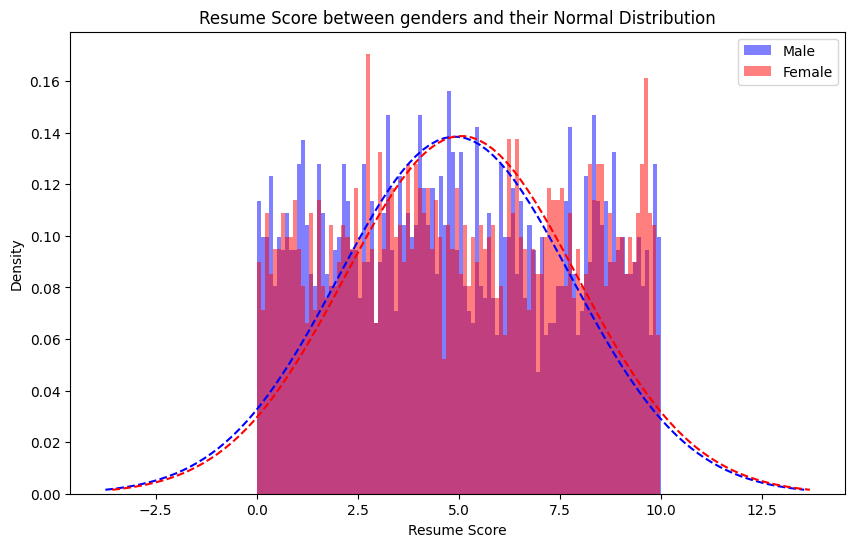

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Example data
data1 = applicants[applicants['Gender'] == 'M']['Resume score']
data2 = applicants[applicants['Gender'] == 'F']['Resume score']

# Create a figure and an axes.
plt.figure(figsize=(10, 6))

# Plot histogram for each series
n1, bins1, patches1 = plt.hist(data1, bins=100, alpha=0.5, label='Male', color='blue', density=True)
n2, bins2, patches2 = plt.hist(data2, bins=100, alpha=0.5, label='Female', color='red', density=True)

# Calculate the mean and standard deviation for each series
mu1, std1 = data1.mean(), data1.std()
mu2, std2 = data2.mean(), data2.std()

# Generate points on the x axis:
factor = 3
x1 = np.linspace(mu1 - factor*std1, mu1 + factor*std1, 100)
x2 = np.linspace(mu2 - factor*std2, mu2 + factor*std2, 100)

# Plot the normal distribution curve
plt.plot(x1, norm.pdf(x1, mu1, std1), 'b--')  # Blue dashed line for Series 1
plt.plot(x2, norm.pdf(x2, mu2, std2), 'r--')  # Red dashed line for Series 2

# Adding titles and labels
plt.title('Resume Score between genders and their Normal Distribution')
plt.xlabel('Resume Score')
plt.ylabel('Density')
plt.legend()  # Add a legend
plt.savefig('resume.png')
# Show plot
plt.show()


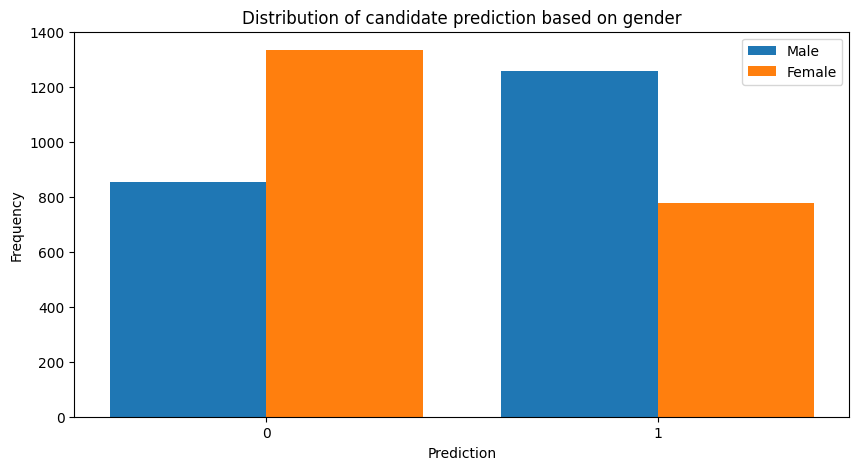

In [12]:
data1 = candidates[candidates['Gender'] == 'M']['prediction']
data2 = candidates[candidates['Gender'] == 'F']['prediction']

# Set up the figure and axes
plt.figure(figsize=(10, 5))

# Plotting
plt.hist([data1, data2], bins=[-0.5, 0.5, 1.5], label=['Male', 'Female'], align='mid', rwidth=0.8)
plt.xticks([0, 1], ['0', '1'])
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Distribution of candidate prediction based on gender')
plt.legend()

# Show the plot
plt.savefig('candidates.png')
plt.show()
